<a href="https://colab.research.google.com/github/shivg7706/BrainTumorSegmentation/blob/master/BrainTumorSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!cp ./drive/My\ Drive/seg_data.zip ./

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip seg_data.zip
!rm -rf seg_data.zip

In [0]:
import requests
from tqdm import tqdm_notebook as tqdm
import os
import argparse



def download_file(url, path):

    if check_if_file_exits(path):
        print(f'Already existing file {path}')
        return

    # Deleting the partial downloaded file.
    if os.path.isfile(path):
        print(f'Deleted existing partial file {path}')
        os.remove(path)

    response = requests.get(url, stream=True)
    handle = open(path, "wb")
    with open(path, "wb") as handle:
        chunk_size = 1024
        total_size = round(int(response.headers['Content-Length']), 3)
        pbar = tqdm(unit="B", total=total_size)
        for chunk in response.iter_content(chunk_size=chunk_size):
            if chunk:  # filter out keep-alive new chunks
                handle.write(chunk)
                pbar.update(len(chunk))


    extension = path[-3:]
    os.rename(path, path[:-4]+'_done.'+extension)


def make_folder(target_folder):

    if not (os.path.isdir(target_folder)):
        print(f'Creating {target_folder} folder')
        os.mkdir(target_folder)


def main():

    dataset_urls = ['https://ndownloader.figshare.com/files/3381290',
                    'https://ndownloader.figshare.com/files/3381296',
                    'https://ndownloader.figshare.com/files/3381293',
                    'https://ndownloader.figshare.com/files/3381302']

    dataset_readme = 'https://ndownloader.figshare.com/files/7953679'

    target_folder = 'dataset'
    dataset_part = 1
    dataset_file_name = f'brain_tumor_dataset_part_'

    make_folder(target_folder)

    print('Downloading dataset README.txt\n')
    download_file(dataset_readme, os.path.join(target_folder, 'README.TXT'))

    print('Starting download process\n')
    for url in dataset_urls:
        try:
            path = os.path.join(
                target_folder, f'{dataset_file_name}{dataset_part}.zip')
            print(f'\t\tDownloading :  {path}')
            download_file(url, path)
            dataset_part += 1



main()

## Converting Data from `.mat` files into images

In [0]:
!unzip seg_dataset.zip

In [0]:
import h5py
import numpy as np


In [0]:
mapping = {
    1: 'meningioma',
    2: 'glioma',
    3: 'pituitary'
}

In [0]:
def save_it(data):
    
    mpimg.imsave('./tumorImage/{}_tumor_{}.png'.format(data['count'], data['label']), data['image'], cmap='gray', format='png')
    mpimg.imsave('./maskImage/{}_mask_{}.png'.format(data['count'], data['label']), data['mask'], cmap='gray', format='png')
    

In [0]:
import matplotlib.image as mpimg

for file in tqdm(os.listdir('./dataset')):
    f = h5py.File('./dataset/{}'.format(file))
    data = dict()
    data['count'] = file[:-4]
    data['image'] = np.array(f.get('cjdata/image'))
    data['mask'] = np.array(f.get('cjdata/tumorMask'))
    data['label'] = mapping[np.array(f.get('cjdata/label'))[0, 0]]

    save_it(data)
        
        

In [0]:
import os
for i in range(3001, 3065):
    os.rename('./tumor/{}.png'.format(i), '../test_tumor/{}.png'.format(i))

In [0]:
!mv ../test/ ../test_mask

In [0]:
for file in os.listdir('segmentation_dataset/maskImage/'):
    if not os.path.exists('segmentation_dataset/maskImage/mask'):
        os.mkdir('segmentation_dataset/maskImage/mask')
    os.rename('segmentation_dataset/maskImage/{}'.format(file), 'segmentation_dataset/maskImage/mask/{}'.format(file))

In [0]:
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1./255, featurewise_center=True,
                    featurewise_std_normalization=True,
                    rotation_range=90.,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.2)

In [0]:
def combine(img_gen, mask_gen):
    while True:
        yield(img_gen.next(), mask_gen.next())

In [146]:
seed = 7706



img_gen = data_gen.flow_from_directory('segmentation_dataset/tumorImage/', target_size=(512, 512), batch_size=2,
                                       class_mode=None, seed=seed, color_mode='grayscale')
mask_gen = data_gen.flow_from_directory('segmentation_dataset/maskImage/', target_size=(512, 512), batch_size=2,
                                       class_mode=None, seed=seed, color_mode='grayscale')

train_gen = combine(img_gen, mask_gen)

Found 3000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.


In [0]:
cd /content/

/content


In [0]:
from keras.layers.convolutional import Conv2D, ZeroPadding2D, Conv2DTranspose
from keras.layers.pooling import MaxPool2D, AvgPool2D, GlobalAveragePooling2D
from keras.layers import Dense, Flatten, Input, BatchNormalization, Dropout, Activation, Concatenate
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import keras.backend as K
from keras.optimizers import Adam
from keras.utils import plot_model

In [0]:
def get_conv_block(input, filter):
    
    x = input
    
    for i in range(2):
        x = Conv2D(filter, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
    return x

In [0]:
def unet():
    
    inputs = Input((512, 512, 1))
    
    # Encoder
    block1 = get_conv_block(inputs, 64)
    x = MaxPool2D(2)(block1)
    
    block2 = get_conv_block(x, 128)
    x = MaxPool2D(2)(block2)
    
    block3 = get_conv_block(x, 256)
    x = MaxPool2D(2)(block3)
    
    block4 = get_conv_block(x, 512)
    
    # Middle part
    
    x = MaxPool2D(2)(block4)
    x = get_conv_block(x, 1024)
    
    # Decoder
    
    x = Conv2DTranspose(512, kernel_size=2, strides=2)(x)
    x = Concatenate()([block4, x])
    x = get_conv_block(x, 512)
    
    x = Conv2DTranspose(256, kernel_size=2, strides=2)(x)
    x = Concatenate()([block3, x])
    x = get_conv_block(x, 256)
    
    x = Conv2DTranspose(128, kernel_size=2, strides=2)(x)
    x = Concatenate()([block2, x])
    x = get_conv_block(x, 128)
    
    x = Conv2DTranspose(64, kernel_size=2, strides=2)(x)
    x = Concatenate()([block1, x])
    x = get_conv_block(x, 64)
    
    x = Conv2D(1, 1)(x)
    outputs = Activation('sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy", iou_loss_core])
    
    return model

In [159]:
model = unet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 512, 512, 64) 640         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_193 (BatchN (None, 512, 512, 64) 256         conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 512, 512, 64) 0           batch_normalization_193[0][0]    
__________________________________________________________________________________________________
conv2d_205

In [160]:
history = model.fit_generator(train_gen, epochs=10, steps_per_epoch=img_gen.samples//2)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1500/1500 [==============================] - 883s 588ms/step - loss: 0.0708 - acc: 0.9819 - iou_loss_core: 0.9723
Epoch 2/10
1307/1500 [=========================>....] - ETA: 1:51 - loss: 0.0489 - acc: 0.9850 - iou_loss_core: 0.9831

KeyboardInterrupt: ignored

In [0]:
def iou_loss_core(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

In [0]:
model.save('./drive/My Drive/BTS_v2.h5')

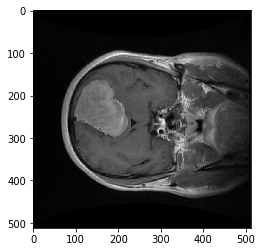

In [150]:
import cv2
img = cv2.imread('segmentation_dataset/tumorImage/tumor/300.png', 0)
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')

In [0]:
import numpy as np
img = img.reshape(1, img.shape[1], img.shape[0], 1)

In [0]:
y_pred = model.predict(img)

In [153]:
y_pred.shape

(1, 512, 512, 1)

In [0]:
y = y_pred.reshape(512, 512)

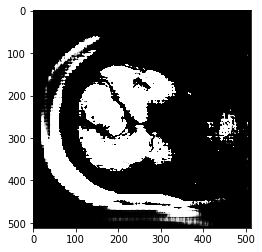

In [155]:
plt.imshow(y, cmap='gray')